In [20]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [21]:
BASE_DATA_FOLDER = "e:/plant_3/"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [22]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [23]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [54]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')
    

def visualize_scatter_2(data_2d, label_ids, data_2d_2, label_ids_2, figsize=(20,20)):
    plt.figure(1, figsize=figsize)
    plt.subplot(2,1,1)
    plt.grid()
    nb_classes = len(np.unique(label_ids))
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')
    
    plt.figure(2, figsize=figsize)
    plt.subplot(2,1,2)
    plt.grid()
    nb_classes = len(np.unique(label_ids_2))
    for label_id in np.unique(label_ids_2):
        plt.scatter(data_2d[np.where(label_ids_2 == label_id), 0],
                    data_2d[np.where(label_ids_2 == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

In [97]:
images = []
labels = []

for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (150, 150))
        image = segment_plant(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

In [98]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [99]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [100]:
images_scaled = StandardScaler().fit_transform(images)

C:\Users\munol\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\munol\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


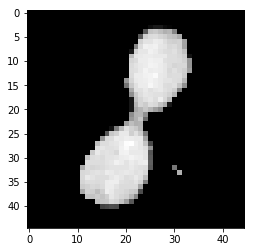

In [101]:
plt.imshow(np.reshape(images[2], (45,45)), cmap="gray")

In [102]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)

In [103]:
tsne = TSNE(n_components=2, perplexity=40.0)

In [104]:
tsne_result = tsne.fit_transform(pca_result)

In [105]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

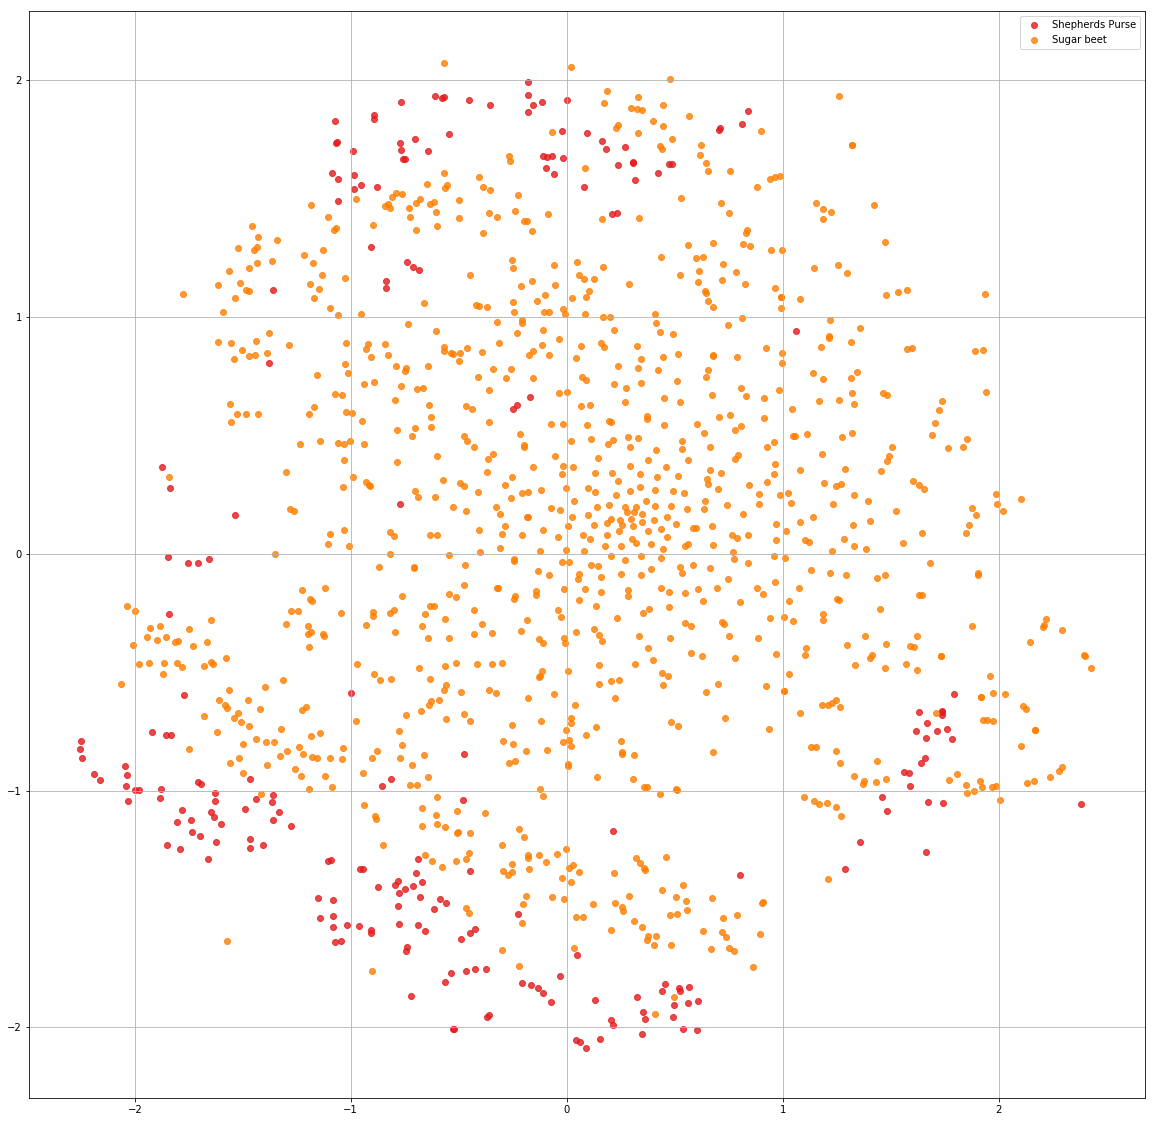

In [106]:
visualize_scatter(tsne_result_scaled, label_ids)

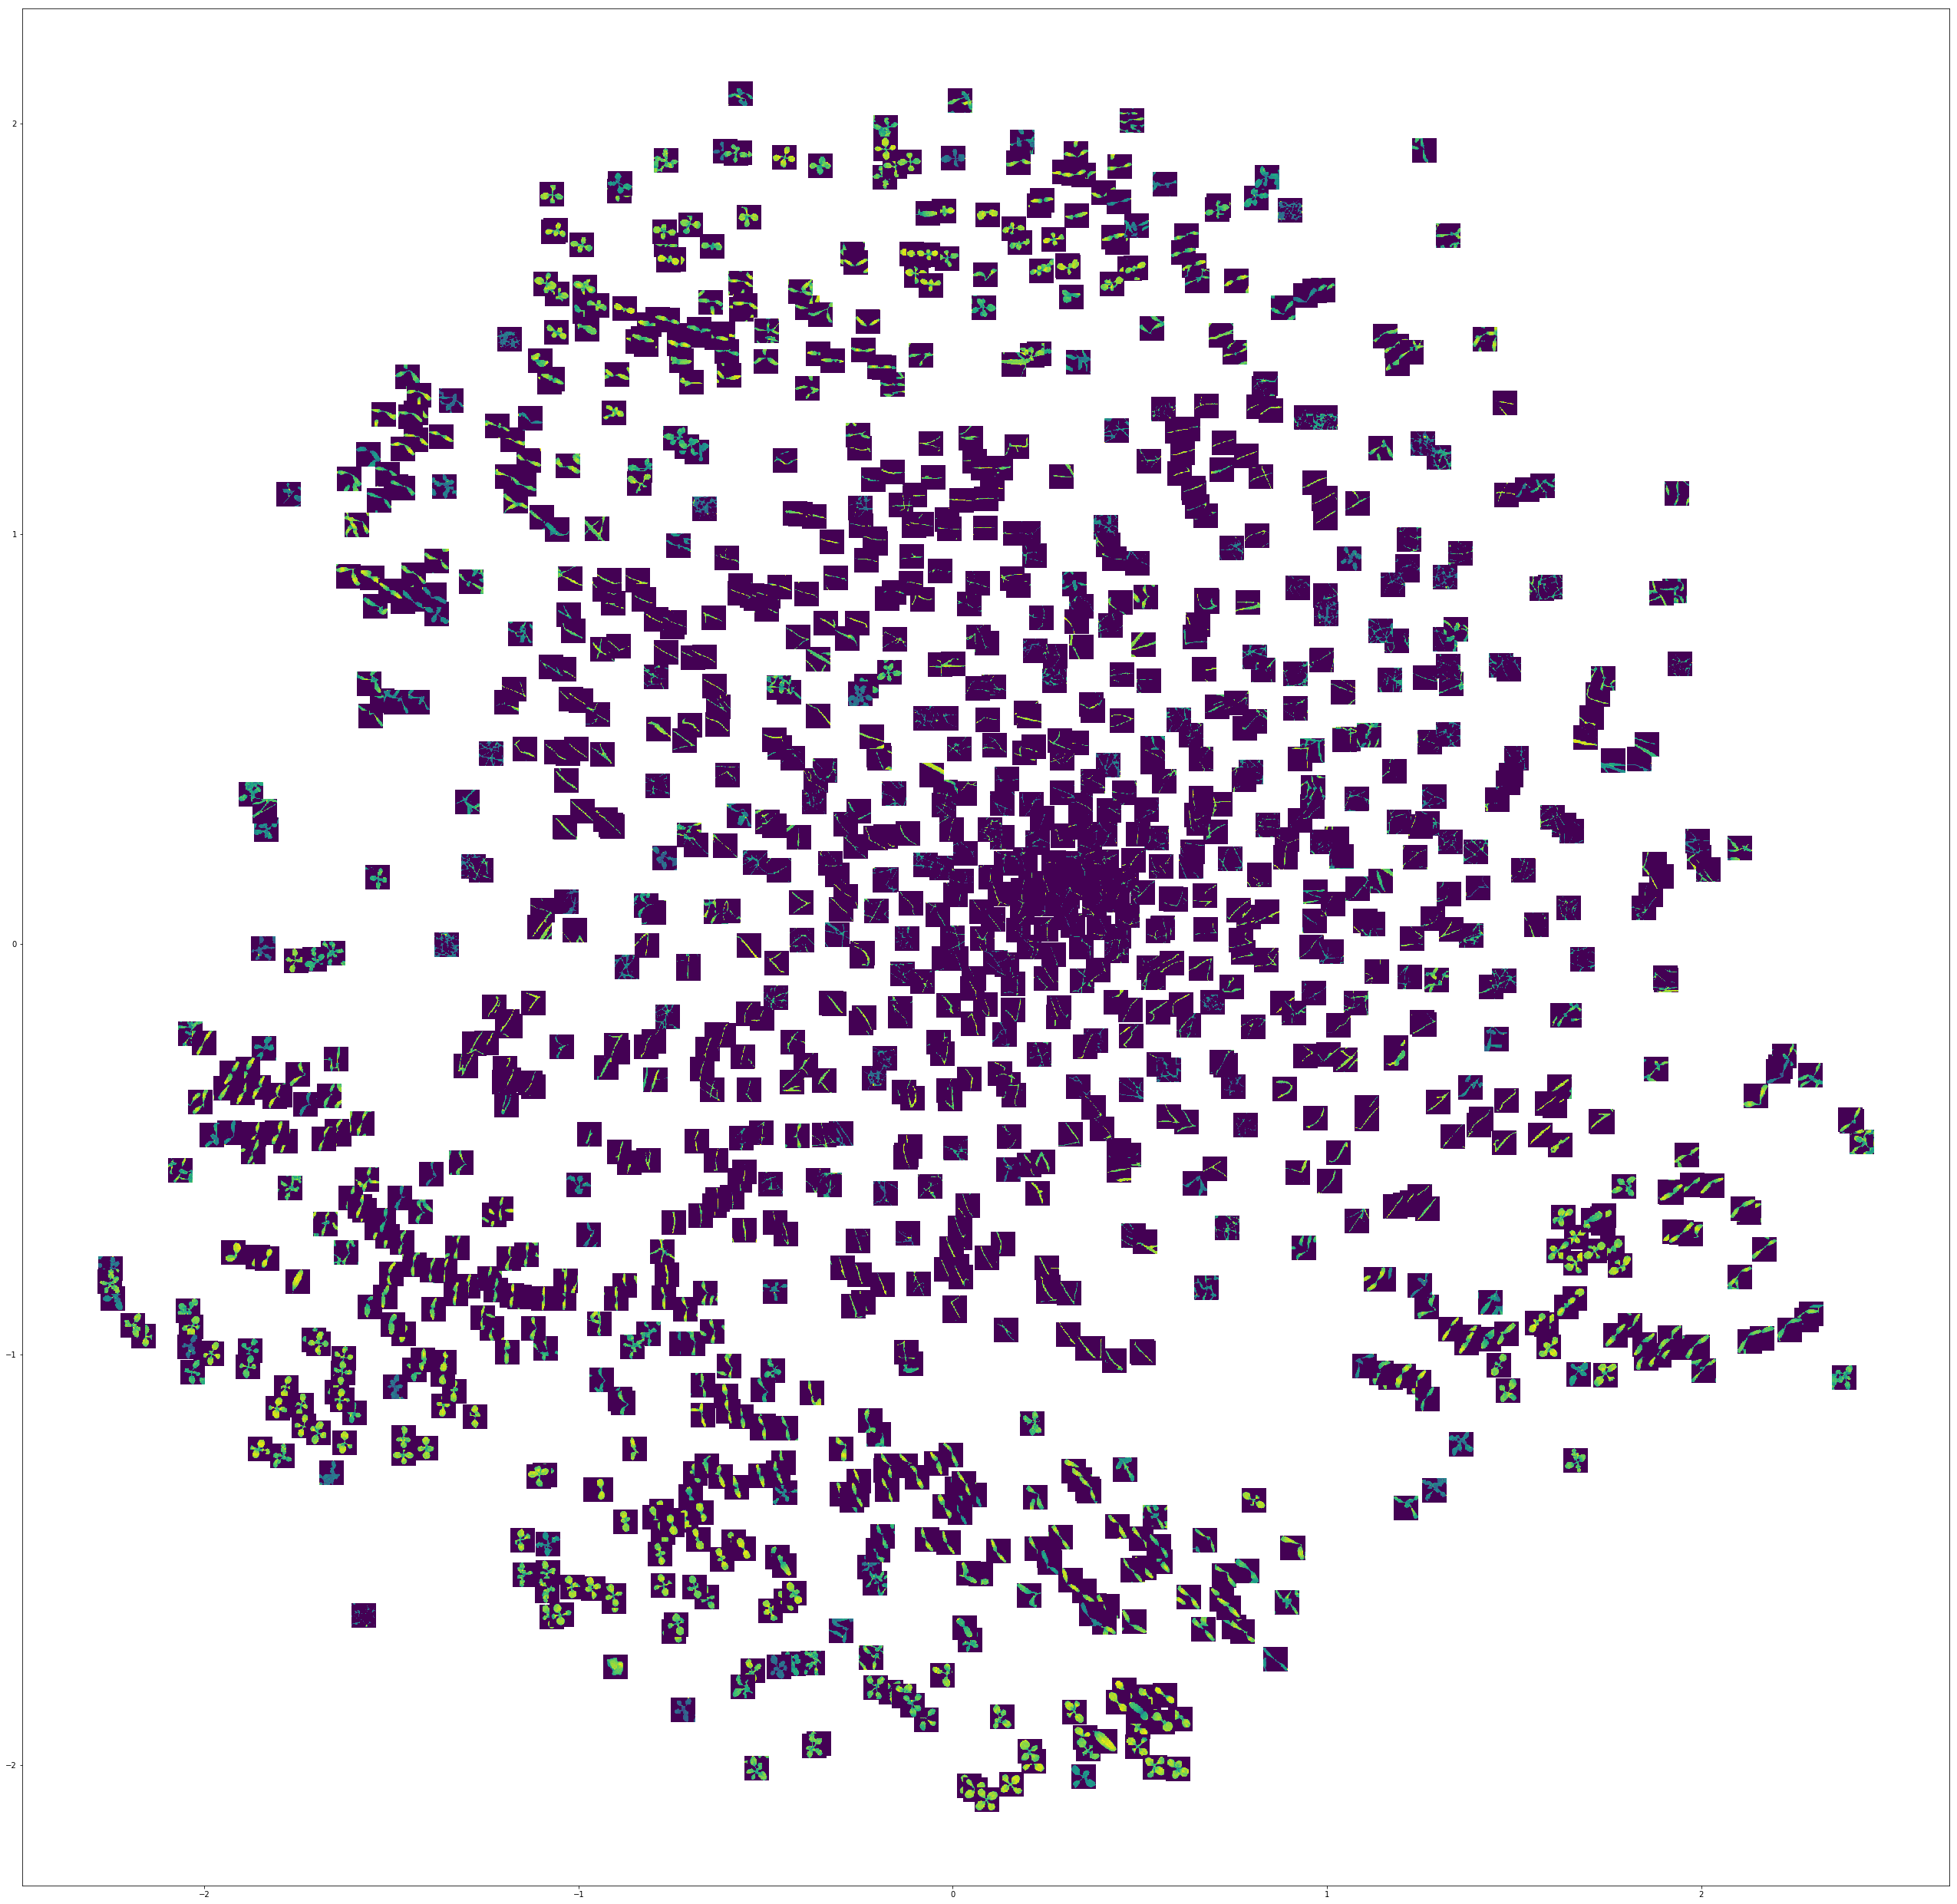

In [107]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)

In [108]:
tsne_result_scaled

array([[ 0.26885018,  1.7165943 ],
       [ 1.483186  , -1.0884118 ],
       [-1.8578087 , -0.7632177 ],
       ...,
       [-0.26057848,  1.661323  ],
       [ 0.28281063, -0.15459524],
       [ 0.58453953, -0.04619896]], dtype=float32)

In [109]:
label_ids

array([0, 0, 0, ..., 1, 1, 1])

In [110]:
from imblearn.over_sampling import ADASYN 
sm = ADASYN()
X, y = sm.fit_sample(tsne_result_scaled, label_ids)

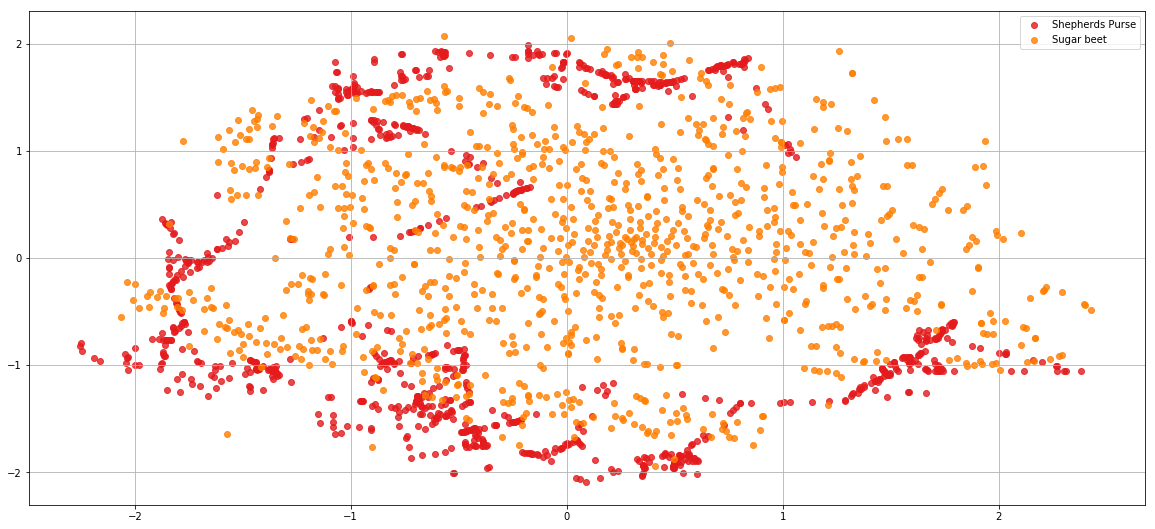

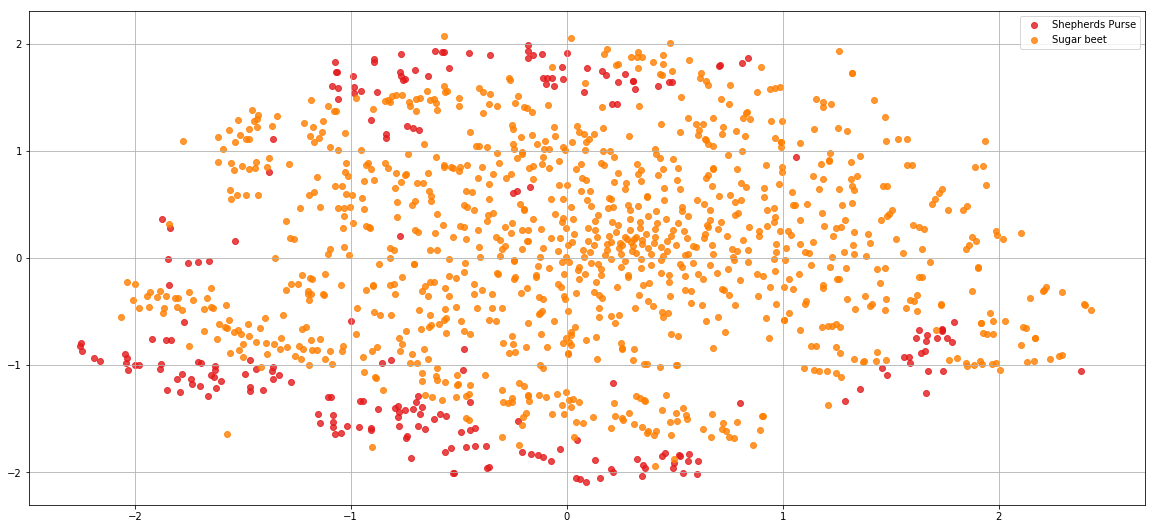

In [111]:
visualize_scatter_2(X, y, tsne_result_scaled, label_ids)

In [112]:
tsne_result_scaled.shape

(1270, 2)

In [113]:
X.shape

(2059, 2)